## Seguimiento 1: Análisis Comparativo de Algoritmos de Ordenamiento

Este notebook implementa y compara **11 algoritmos de ordenamiento** aplicados a campos bibliográficos extraídos de archivos BibTeX.

### Objetivos:
1. **Extraer campos** de archivo BibTeX consolidado
2. **Implementar 11 algoritmos** de ordenamiento
3. **Medir tiempos** de ejecución por algoritmo y campo
4. **Comparar rendimiento** con tablas y gráficas
5. **Analizar autores** más frecuentes

### Flujo del Proceso:
```
Extracción BibTeX → Implementación de Algoritmos → 
Aplicación por Campo → Medición de Tiempos → 
Exportación de Resultados → Visualización → Análisis de Autores
```

### Algoritmos Implementados:

#### 🚀 Algoritmos Eficientes (O(n log n)):
1. **TimSort**: Algoritmo híbrido (Merge + Insertion), usado por Python
2. **Quick Sort**: Divide y conquista con pivote
3. **Heap Sort**: Basado en estructura de heap
4. **Tree Sort**: Árbol binario de búsqueda + recorrido inorden
5. **Radix Sort**: Ordenamiento por dígitos/caracteres (LSD)

#### ⚡ Algoritmos Intermedios:
6. **Comb Sort**: Mejora de Bubble Sort con gap decreciente
7. **Bucket Sort**: Distribución en cubetas + ordenamiento interno
8. **Pigeonhole Sort**: Distribución en casillas por hash

#### 🐌 Algoritmos Básicos (O(n²)):
9. **Selection Sort**: Selección del mínimo iterativa
10. **Gnome Sort**: Similar a Insertion Sort con retroceso
11. **Binary Insertion Sort**: Insertion Sort con búsqueda binaria

### Campos Analizados:
- **author**: Autores de artículos
- **title**: Títulos de publicaciones
- **journal**: Revistas/conferencias
- **year**: Años de publicación
- **doi**: Identificadores digitales
- **keywords**: Palabras clave
- **abstract**: Resúmenes

### 📊 Métricas Evaluadas:
- **Tiempo de ejecución** (segundos)
- **Tamaño del dataset** (número de elementos)
- **Rendimiento relativo** por algoritmo

### Salidas Generadas:
```
ordenamiento/
├── author.txt          # Resultados ordenados por autor
├── title.txt           # Resultados ordenados por título
├── journal.txt         # Resultados ordenados por revista
├── year.txt            # Resultados ordenados por año
├── doi.txt             # Resultados ordenados por DOI
├── keywords.txt        # Resultados ordenados por keywords
└── abstract.txt        # Resultados ordenados por abstract

tiempos/
├── tiempo-ordenamiento.txt    # CSV con tiempos
├── tabla_resultados.csv       # Tabla completa
├── tabla_resultados.md        # Tabla en Markdown
├── tiempo_author.png          # Gráfica de tiempos
├── tiempo_title.png
└── ...
```

### Variables de Entorno:
```python
CONSOLIDADO_PATH    # Ruta del archivo BibTeX consolidado
ORDENAMIENTO_PATH   # Carpeta de salida para resultados
TIEMPOS_PATH        # Carpeta de salida para métricas
```

### 📚 Tecnologías Utilizadas:
- **Python**: Lenguaje base
- **NumPy**: Operaciones numéricas
- **Pandas**: Tablas de resultados
- **Matplotlib**: Visualizaciones
- **heapq**: Implementación de Heap Sort
- **bisect**: Búsqueda binaria
- **re**: Expresiones regulares para parsing

---

⚠️ Error en quicksort con el campo year: maximum recursion depth exceeded

📊 Resultados de ejecución:

   Campo           Algoritmo  Tamaño  Tiempo (s)
  author             timsort   10213    0.002881
  author            combsort   10213    0.041181
  author       selectionsort   10213    2.715064
  author            treesort   10213    0.021253
  author      pigeonholesort   10213    0.406183
  author          bucketsort   10213    0.003095
  author           quicksort   10213    0.013562
  author            heapsort   10213    0.004446
  author           gnomesort   10213    8.129566
  author binaryInsertionsort   10213    0.036522
  author           radixsort   10213    0.955400
   title             timsort   10213    0.003108
   title            combsort   10213    0.049086
   title       selectionsort   10213    3.366073
   title            treesort   10213    0.015048
   title      pigeonholesort   10213    0.580453
   title          bucketsort   10213    0.004440
   title       

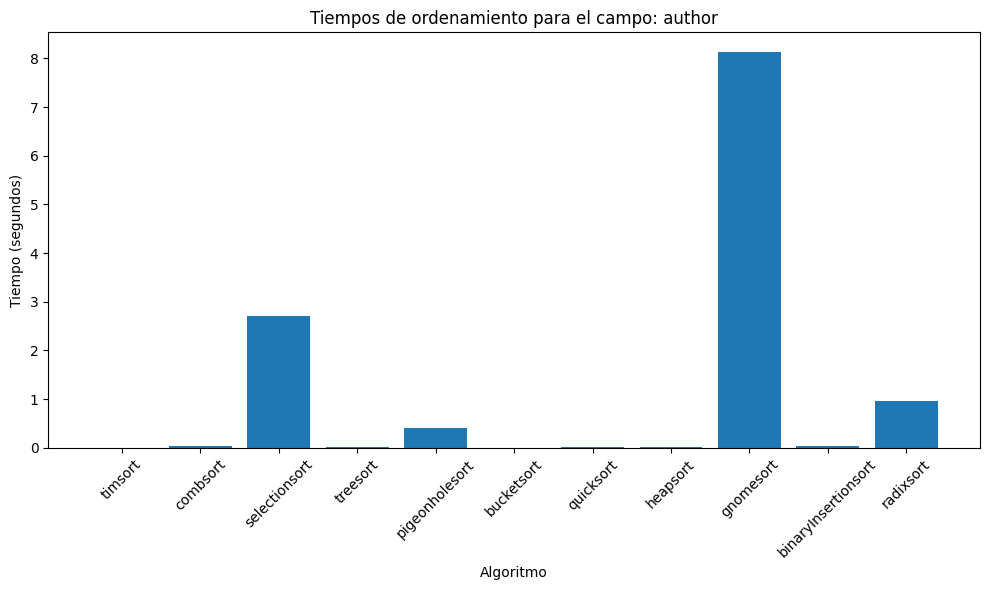

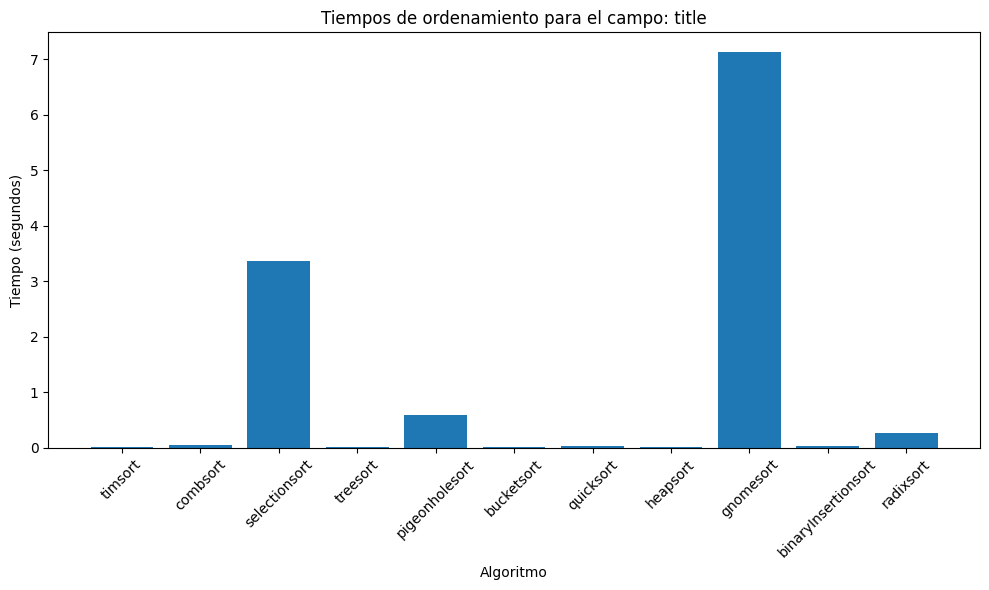

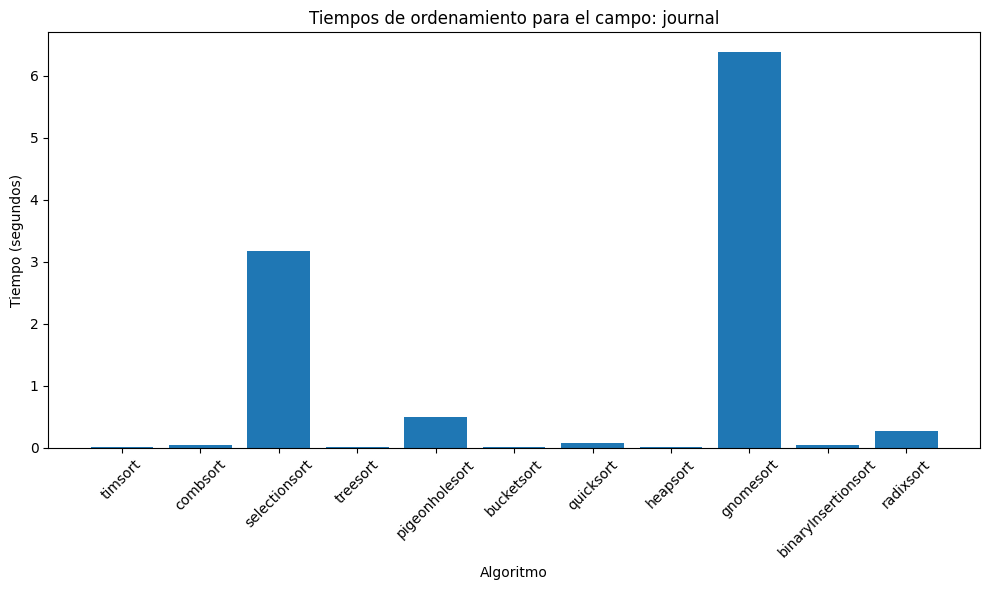

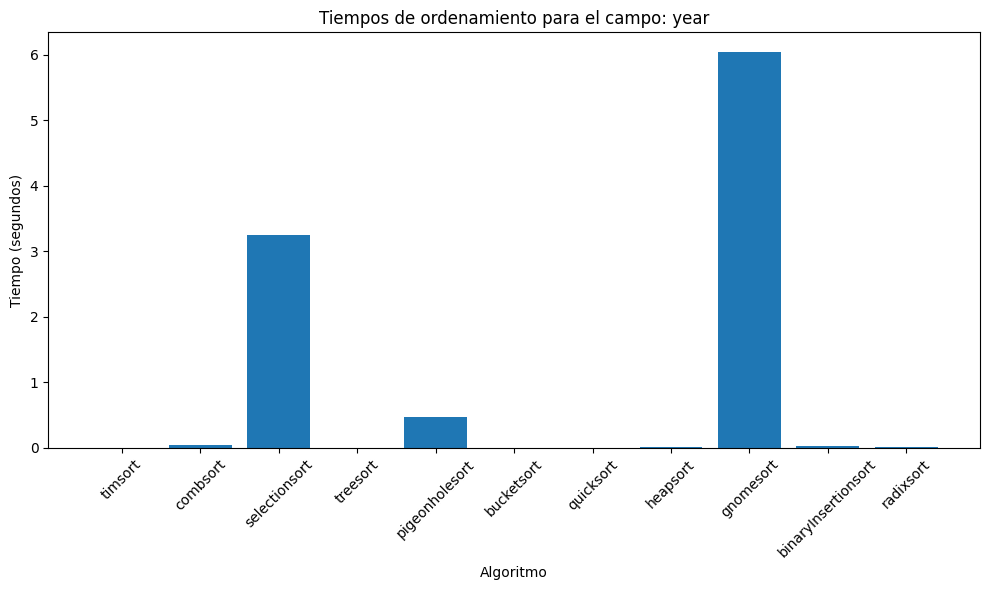

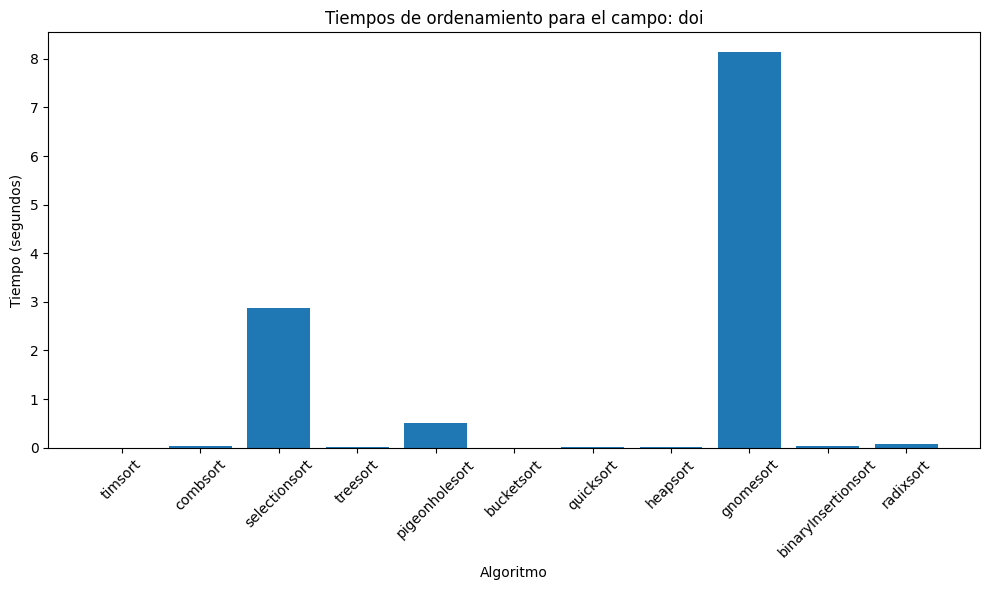

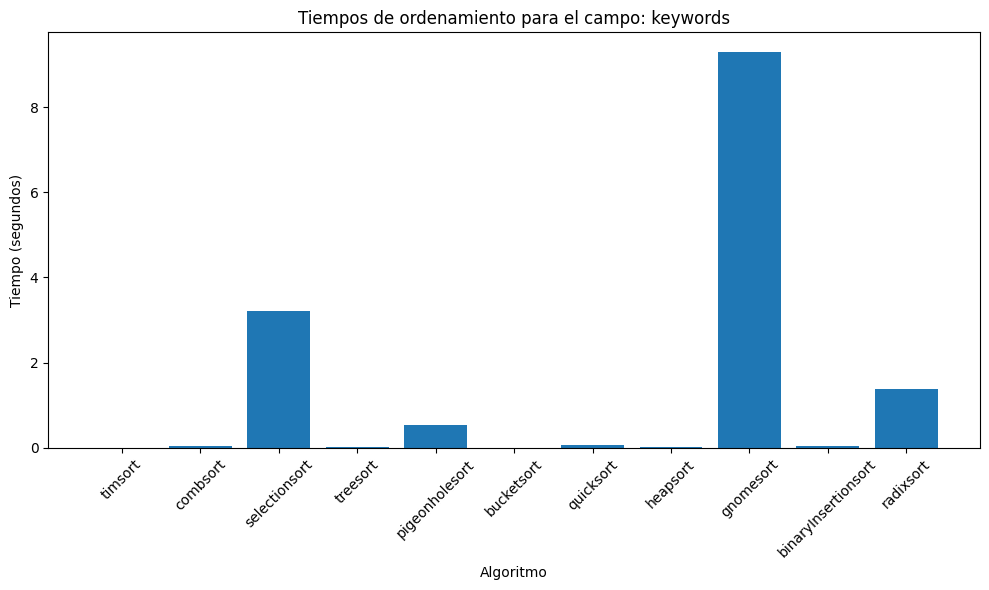

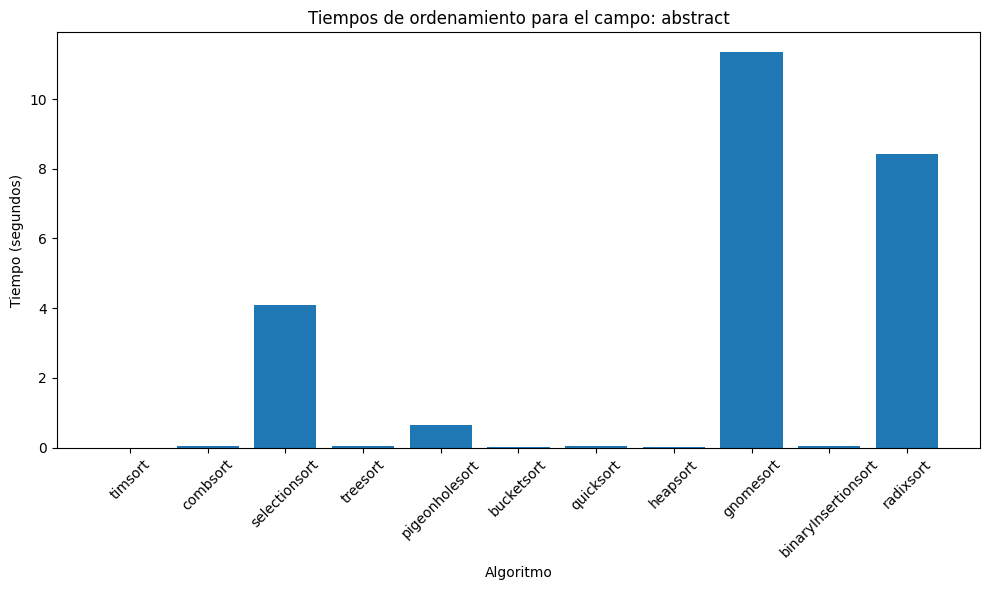

In [1]:
import os
import re
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import heapq
from functools import cmp_to_key
from collections import defaultdict
import math
import bisect

from dotenv import load_dotenv

# Cargar variables de entorno desde .env
load_dotenv()

# Definir rutas
BIBTEX_PATH =os.getenv("CONSOLIDADO_PATH")
OUTPUT_PATH = os.getenv("ORDENAMIENTO_PATH")
TIMING_PATH = os.getenv("TIEMPOS_PATH")

# Crear directorios si no existen
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)
Path(TIMING_PATH).mkdir(parents=True, exist_ok=True)

# %%
def extract_bibtex_fields(file_path):
    """
    Extrae los campos de un archivo BibTeX.
    Se buscan las claves: author, title, journal, year, doi, keywords y abstract.
    Para journal se considera también booktitle.
    Si un campo no existe se asigna como cadena vacía.
    """
    fields = {
        'author': [],
        'title': [],
        'journal': [],
        'year': [],
        'doi': [],
        'keywords': [],
        'abstract': []
    }
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Buscar entradas BibTeX (cualquier tipo: article, inproceedings, etc.)
        entries = re.findall(r'@\w+\s*\{[^@]*\}', content, re.DOTALL)
        
        for entry in entries:
            for field in fields.keys():
                # Buscar el campo en la entrada, manejando {valor} o "valor"
                pattern = rf'{field}\s*=\s*[\{{\"](.*?)[\}}\"]'
                match = re.search(pattern, entry, re.IGNORECASE | re.DOTALL)
                
                # Para journal, buscar booktitle si no se encontró journal
                if field == 'journal' and not match:
                    pattern = r'booktitle\s*=\s*[\{{\"](.*?)[\}}\"]'
                    match = re.search(pattern, entry, re.IGNORECASE | re.DOTALL)
                
                if match:
                    value = match.group(1).strip()
                    fields[field].append(value)
                else:
                    fields[field].append("")
        
        return fields
        
    except Exception as e:
        print(f"Error al procesar el archivo BibTeX: {e}")
        return fields

# %%
# Implementación de Algoritmos de Ordenamiento

# 1. TimSort (usando sorted de Python, que es TimSort)
def timsort(arr):
    return sorted(arr)

# 2. Comb Sort
def combsort(arr):
    arr = arr.copy()
    n = len(arr)
    gap = n
    shrink = 1.3
    sorted_flag = False
    
    while not sorted_flag:
        gap = int(gap / shrink)
        if gap <= 1:
            gap = 1
            sorted_flag = True
        
        i = 0
        while i + gap < n:
            if arr[i] > arr[i + gap]:
                arr[i], arr[i + gap] = arr[i + gap], arr[i]
                sorted_flag = False
            i += 1
    
    return arr

# 3. Selection Sort
def selectionsort(arr):
    arr = arr.copy()
    n = len(arr)
    
    for i in range(n):
        min_idx = i
        for j in range(i+1, n):
            if arr[j] < arr[min_idx]:
                min_idx = j
        arr[i], arr[min_idx] = arr[min_idx], arr[i]
    
    return arr

# 4. Tree Sort (con eliminación de duplicados antes de insertar)
class Nodo:
    def __init__(self, clave):
        self.clave = clave
        self.izq = None
        self.der = None

def insertar(raiz, clave):
    if raiz is None:
        return Nodo(clave)
    if clave < raiz.clave:
        raiz.izq = insertar(raiz.izq, clave)
    else:
        raiz.der = insertar(raiz.der, clave)
    return raiz

def inorden(raiz, resultado):
    if raiz is not None:
        inorden(raiz.izq, resultado)
        resultado.append(raiz.clave)
        inorden(raiz.der, resultado)

def treesort(arr):
    if not arr:
        return []
    raiz = None
    # 🔑 usamos set() para eliminar duplicados ANTES de insertar
    for item in set(arr):
        clave = str(item).strip().lower()
        raiz = insertar(raiz, clave)
    resultado = []
    inorden(raiz, resultado)
    return resultado


# 5. Pigeonhole Sort
def pigeonholesort(arr):
    if not arr:
        return []
    
    min_val = 0
    max_val = 0
    
    str_to_num = {}
    for i, s in enumerate(arr):
        if s == "":
            val = -1  # Manejar cadenas vacías
        else:
            val = hash(s) % 1000000  # Limitar el rango
        str_to_num[s] = val
        
        if i == 0 or val < min_val:
            min_val = val
        if i == 0 or val > max_val:
            max_val = val
    
    size = max_val - min_val + 1
    holes = [[] for _ in range(size)]
    
    for s in arr:
        val = str_to_num[s]
        holes[val - min_val].append(s)
    
    result = []
    for hole in holes:
        result.extend(sorted(hole))
    
    return result

# 6. Bucket Sort
def bucketsort(arr):
    if not arr:
        return []
    
    buckets = defaultdict(list)
    
    for s in arr:
        key = s[0].lower() if s != "" else ""
        buckets[key].append(s)
    
    result = []
    for key in sorted(buckets.keys()):
        result.extend(sorted(buckets[key]))
    
    return result

# 7. Quick Sort
def quicksort(arr):
    arr = arr.copy()
    
    def _quicksort(arr, low, high):
        if low < high:
            pi = partition(arr, low, high)
            _quicksort(arr, low, pi - 1)
            _quicksort(arr, pi + 1, high)
    
    def partition(arr, low, high):
        pivot = arr[high]
        i = low - 1
        
        for j in range(low, high):
            if arr[j] <= pivot:
                i += 1
                arr[i], arr[j] = arr[j], arr[i]
        arr[i + 1], arr[high] = arr[high], arr[i + 1]
        return i + 1
    
    _quicksort(arr, 0, len(arr) - 1)
    return arr

# 8. Heap Sort
def heapsort(arr):
    heap = arr.copy()
    heapq.heapify(heap)
    result = []
    while heap:
        result.append(heapq.heappop(heap))
    return result

# 9. Gnome Sort
def gnomesort(arr):
    arr = arr.copy()
    n = len(arr)
    pos = 0
    
    while pos < n:
        if pos == 0 or arr[pos] >= arr[pos - 1]:
            pos += 1
        else:
            arr[pos], arr[pos - 1] = arr[pos - 1], arr[pos]
            pos -= 1
    
    return arr

# 10. Binary Insertion Sort
def binaryInsertionsort(arr):
    arr = arr.copy()
    for i in range(1, len(arr)):
        key = arr[i]
        lo, hi = 0, i
        while lo < hi:
            mid = (lo + hi) // 2
            if arr[mid] <= key:
                lo = mid + 1
            else:
                hi = mid
        arr.insert(lo, arr.pop(i))
    return arr

# 11. Radix Sort para strings (LSD)
def radixsort(arr):
    if not arr:
        return []
    # Encontrar la longitud máxima de las cadenas
    max_len = max(len(s) for s in arr)
    # Procesar desde el último carácter hasta el primero
    for pos in range(max_len - 1, -1, -1):
        buckets = {}
        for s in arr:
            # Si la cadena es muy corta, usamos "" (que se ordena antes)
            key = s[pos] if pos < len(s) else ""
            buckets.setdefault(key, []).append(s)
        sorted_keys = sorted(buckets.keys())
        arr = []
        for key in sorted_keys:
            arr.extend(buckets[key])
    return arr

# %%
# Diccionario de algoritmos a utilizar
algorithms = {
    'timsort': timsort,
    'combsort': combsort,
    'selectionsort': selectionsort,
    'treesort': treesort,
    'pigeonholesort': pigeonholesort,
    'bucketsort': bucketsort,
    'quicksort': quicksort,
    'heapsort': heapsort,
    'gnomesort': gnomesort,
    'binaryInsertionsort': binaryInsertionsort,
    'radixsort': radixsort
}

# %%
# Extraer campos del archivo BibTeX
fields = extract_bibtex_fields(BIBTEX_PATH)

# Diccionarios para almacenar resultados ordenados y tiempos
sorted_results = { key: {} for key in fields.keys() }
timings = { key: {} for key in fields.keys() }

# Para cada campo, aplicar cada algoritmo y medir el tiempo de ejecución
import random

for field, values in fields.items():
    # Saltar campos vacíos
    if not values:
        print(f"⚠️ El campo '{field}' está vacío, omitiendo...")
        continue
        
    for algo_name, algo_func in algorithms.items():
        try:
            # Hacer una copia de values para no modificar el original
            values_to_sort = values.copy()
            start_time = time.time()
            sorted_list = algo_func(values_to_sort)
            end_time = time.time()
            elapsed = (end_time - start_time)
            
            sorted_results[field][algo_name] = sorted_list
            timings[field][algo_name] = elapsed
        except Exception as e:
            print(f"⚠️ Error en {algo_name} con el campo {field}: {str(e)}")
            sorted_results[field][algo_name] = []
            timings[field][algo_name] = float("nan")

# %%
# Escribir archivos de salida para cada clave en OUTPUT_PATH
for field, algo_results in sorted_results.items():
    file_path = os.path.join(OUTPUT_PATH, f"{field}.txt")
    with open(file_path, 'w', encoding='utf-8') as f:
        for algo_name in algorithms.keys():
            f.write(f"# ordenamiento por {algo_name}\n")
            for item in algo_results[algo_name]:
                f.write(item + "\n")
            f.write("\n")

# %%
# Escribir archivo con tiempos de ordenamiento en TIMING_PATH
timing_file = os.path.join(TIMING_PATH, "tiempo-ordenamiento.txt")
with open(timing_file, 'w', encoding='utf-8') as f:
    f.write("Campo,Algoritmo,Tiempo (segundos)\n")
    for field, algo_times in timings.items():
        for algo_name, t in algo_times.items():
            f.write(f"{field},{algo_name},{t}\n")

# %% 
# Crear tabla con tamaño y tiempo de cada algoritmo por campo
resultados_tabla = []

for field, algo_times in timings.items():
    tamaño = len(fields[field])  # número de elementos de ese campo
    for algo_name, t in algo_times.items():
        resultados_tabla.append({
            "Campo": field,
            "Algoritmo": algo_name,
            "Tamaño": tamaño,
            "Tiempo (s)": round(t, 6)
        })

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados_tabla)

# Mostrar tabla en pantalla
print("\n📊 Resultados de ejecución:\n")
print(df_resultados.to_string(index=False))

# Exportar a CSV y Markdown
csv_path = os.path.join(TIMING_PATH, "tabla_resultados.csv")
md_path = os.path.join(TIMING_PATH, "tabla_resultados.md")

df_resultados.to_csv(csv_path, index=False)

with open(md_path, "w", encoding="utf-8") as f:
    f.write(df_resultados.to_markdown(index=False))

print(f"\nTablas exportadas a:\n- {csv_path}\n- {md_path}")


# %%
# Graficar tiempos de ordenamiento para cada clave
for field, algo_times in timings.items():
    algo_names = list(algo_times.keys())
    times_list = [algo_times[algo] for algo in algo_names]
    
    plt.figure(figsize=(10,6))
    plt.bar(algo_names, times_list)
    plt.xlabel('Algoritmo')
    plt.ylabel('Tiempo (segundos)')
    plt.title(f'Tiempos de ordenamiento para el campo: {field}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Guardar la gráfica en TIMING_PATH (por ejemplo, "tiempo_author.png")
    plt.savefig(os.path.join(TIMING_PATH, f"tiempo_{field}.png"))
    plt.show()

### Implementación Completa: Extracción, Algoritmos y Análisis

Esta celda contiene todo el código del análisis de ordenamiento.

---

## 📦 Parte 1: Configuración y Extracción

### Importaciones y Variables de Entorno:

```python
import os, re, time, random, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd, heapq
from functools import cmp_to_key
from collections import defaultdict
import math, bisect
from dotenv import load_dotenv
```

### Función de Extracción BibTeX:

```python
def extract_bibtex_fields(file_path):
    """
    Extrae 7 campos clave de un archivo BibTeX.
    """
    fields = {
        'author': [], 'title': [], 'journal': [],
        'year': [], 'doi': [], 'keywords': [], 'abstract': []
    }
```

#### Proceso de Extracción:

1. **Leer archivo completo**:
```python
with open(file_path, 'r', encoding='utf-8') as f:
    content = f.read()
```

2. **Encontrar entradas BibTeX**:
```python
entries = re.findall(r'@\w+\s*\{[^@]*\}', content, re.DOTALL)
```
**Regex**: `@\w+\s*\{[^@]*\}` captura desde `@article{` hasta el `}` de cierre

3. **Extraer campos con regex**:
```python
pattern = rf'{field}\s*=\s*[\{{\"](.*?)[\}}\"]'
match = re.search(pattern, entry, re.IGNORECASE | re.DOTALL)
```

4. **Manejo especial de journal**:
```python
# Si no hay journal, buscar booktitle (para conferencias)
if field == 'journal' and not match:
    pattern = r'booktitle\s*=\s*[\{{\"](.*?)[\}}\"]'
    match = re.search(pattern, entry, re.IGNORECASE | re.DOTALL)
```

---

## 🔧 Parte 2: Implementación de Algoritmos

### 1. TimSort (Python's Built-in)

```python
def timsort(arr):
    return sorted(arr)
```

**Características**:
- Algoritmo híbrido: Merge Sort + Insertion Sort
- Usado por Python y Java
- Complejidad: O(n log n)
- Estable: Mantiene orden relativo
- Optimizado para datos parcialmente ordenados

**Ventajas**:
- ✅ Muy rápido en la práctica
- ✅ Estable
- ✅ Adaptativo (mejor con datos ordenados)

---

### 2. Comb Sort

```python
def combsort(arr):
    arr = arr.copy()
    n = len(arr)
    gap = n
    shrink = 1.3  # Factor de reducción
    sorted_flag = False
    
    while not sorted_flag:
        gap = int(gap / shrink)
        if gap <= 1:
            gap = 1
            sorted_flag = True
        
        i = 0
        while i + gap < n:
            if arr[i] > arr[i + gap]:
                arr[i], arr[i + gap] = arr[i + gap], arr[i]
                sorted_flag = False
            i += 1
    
    return arr
```

**Características**:
- Mejora de Bubble Sort
- Complejidad: O(n²/2^p) donde p es el número de incrementos
- Gap inicial: tamaño del array
- Factor de reducción: 1.3 (óptimo empíricamente)

**Algoritmo**:
1. Iniciar con gap = n
2. Comparar elementos separados por gap
3. Reducir gap por factor 1.3
4. Repetir hasta gap = 1

---

### 3. Selection Sort

```python
def selectionsort(arr):
    arr = arr.copy()
    n = len(arr)
    
    for i in range(n):
        min_idx = i
        for j in range(i+1, n):
            if arr[j] < arr[min_idx]:
                min_idx = j
        arr[i], arr[min_idx] = arr[min_idx], arr[i]
    
    return arr
```

**Características**:
- Complejidad: O(n²)
- No estable
- Mínimo número de intercambios: O(n)

**Algoritmo**:
1. Encontrar el mínimo en el subarreglo no ordenado
2. Intercambiarlo con el primer elemento no ordenado
3. Repetir para el resto del array

---

### 4. Tree Sort

```python
class Nodo:
    def __init__(self, clave):
        self.clave = clave
        self.izq = None
        self.der = None

def insertar(raiz, clave):
    if raiz is None:
        return Nodo(clave)
    if clave < raiz.clave:
        raiz.izq = insertar(raiz.izq, clave)
    else:
        raiz.der = insertar(raiz.der, clave)
    return raiz

def inorden(raiz, resultado):
    if raiz is not None:
        inorden(raiz.izq, resultado)
        resultado.append(raiz.clave)
        inorden(raiz.der, resultado)

def treesort(arr):
    if not arr:
        return []
    raiz = None
    # Eliminar duplicados con set()
    for item in set(arr):
        clave = str(item).strip().lower()
        raiz = insertar(raiz, clave)
    resultado = []
    inorden(raiz, resultado)
    return resultado
```

**Características**:
- Basado en Árbol Binario de Búsqueda (BST)
- Complejidad: O(n log n) promedio, O(n²) peor caso
- Recorrido inorden produce lista ordenada

**Algoritmo**:
1. Construir BST insertando elementos
2. Recorrer en inorden (izq → raíz → der)
3. Resultado es lista ordenada

**Optimización**: Usa `set()` para eliminar duplicados antes de insertar

---

### 5. Pigeonhole Sort

```python
def pigeonholesort(arr):
    if not arr:
        return []
    
    # Mapear strings a números con hash
    str_to_num = {}
    for i, s in enumerate(arr):
        if s == "":
            val = -1
        else:
            val = hash(s) % 1000000  # Limitar rango
        str_to_num[s] = val
        
        if i == 0 or val < min_val:
            min_val = val
        if i == 0 or val > max_val:
            max_val = val
    
    # Crear casillas
    size = max_val - min_val + 1
    holes = [[] for _ in range(size)]
    
    # Distribuir en casillas
    for s in arr:
        val = str_to_num[s]
        holes[val - min_val].append(s)
    
    # Recolectar ordenado
    result = []
    for hole in holes:
        result.extend(sorted(hole))
    
    return result
```

**Características**:
- Complejidad: O(n + Range)
- Eficiente cuando Range ≈ n
- Requiere conocer rango de valores

**Algoritmo**:
1. Encontrar min y max
2. Crear casillas (holes) para cada valor posible
3. Distribuir elementos en casillas
4. Recolectar en orden

**Adaptación para strings**: Usa hash para convertir strings a números

---

### 6. Bucket Sort

```python
def bucketsort(arr):
    if not arr:
        return []
    
    buckets = defaultdict(list)
    
    # Distribuir por primera letra
    for s in arr:
        key = s[0].lower() if s != "" else ""
        buckets[key].append(s)
    
    # Ordenar cada bucket y concatenar
    result = []
    for key in sorted(buckets.keys()):
        result.extend(sorted(buckets[key]))
    
    return result
```

**Características**:
- Complejidad: O(n + k) donde k es número de buckets
- Eficiente para distribución uniforme

**Algoritmo**:
1. Distribuir elementos en buckets por criterio (primera letra)
2. Ordenar cada bucket individualmente
3. Concatenar buckets en orden

---

### 7. Quick Sort

```python
def quicksort(arr):
    arr = arr.copy()
    
    def _quicksort(arr, low, high):
        if low < high:
            pi = partition(arr, low, high)
            _quicksort(arr, low, pi - 1)
            _quicksort(arr, pi + 1, high)
    
    def partition(arr, low, high):
        pivot = arr[high]
        i = low - 1
        
        for j in range(low, high):
            if arr[j] <= pivot:
                i += 1
                arr[i], arr[j] = arr[j], arr[i]
        arr[i + 1], arr[high] = arr[high], arr[i + 1]
        return i + 1
    
    _quicksort(arr, 0, len(arr) - 1)
    return arr
```

**Características**:
- Complejidad: O(n log n) promedio, O(n²) peor caso
- Divide y conquista
- In-place (no requiere memoria extra)

**Algoritmo**:
1. Elegir pivote (último elemento)
2. Particionar: elementos menores a la izquierda, mayores a la derecha
3. Recursivamente ordenar subarreglos

---

### 8. Heap Sort

```python
def heapsort(arr):
    heap = arr.copy()
    heapq.heapify(heap)  # Convertir a min-heap
    result = []
    while heap:
        result.append(heapq.heappop(heap))
    return result
```

**Características**:
- Complejidad: O(n log n)
- Usa estructura de heap (montículo)
- No requiere memoria extra

**Algoritmo**:
1. Construir heap (heapify): O(n)
2. Extraer mínimo n veces: O(n log n)

---

### 9. Gnome Sort

```python
def gnomesort(arr):
    arr = arr.copy()
    n = len(arr)
    pos = 0
    
    while pos < n:
        if pos == 0 or arr[pos] >= arr[pos - 1]:
            pos += 1
        else:
            arr[pos], arr[pos - 1] = arr[pos - 1], arr[pos]
            pos -= 1
    
    return arr
```

**Características**:
- Complejidad: O(n²)
- Similar a Insertion Sort
- Retrocede cuando encuentra desorden

**Algoritmo**:
1. Avanzar si elemento está en orden
2. Retroceder e intercambiar si está desordenado
3. Repetir hasta llegar al final

---

### 10. Binary Insertion Sort

```python
def binaryInsertionsort(arr):
    arr = arr.copy()
    for i in range(1, len(arr)):
        key = arr[i]
        # Búsqueda binaria para encontrar posición
        lo, hi = 0, i
        while lo < hi:
            mid = (lo + hi) // 2
            if arr[mid] <= key:
                lo = mid + 1
            else:
                hi = mid
        arr.insert(lo, arr.pop(i))
    return arr
```

**Características**:
- Complejidad: O(n²) pero menos comparaciones
- Usa búsqueda binaria para encontrar posición

**Algoritmo**:
1. Para cada elemento, buscar posición con búsqueda binaria
2. Insertar en la posición encontrada

---

### 11. Radix Sort (LSD)

```python
def radixsort(arr):
    if not arr:
        return []
    # Encontrar longitud máxima
    max_len = max(len(s) for s in arr)
    # Procesar desde el último carácter (LSD)
    for pos in range(max_len - 1, -1, -1):
        buckets = {}
        for s in arr:
            key = s[pos] if pos < len(s) else ""
            buckets.setdefault(key, []).append(s)
        sorted_keys = sorted(buckets.keys())
        arr = []
        for key in sorted_keys:
            arr.extend(buckets[key])
    return arr
```

**Características**:
- Complejidad: O(d × n) donde d es número de dígitos/caracteres
- LSD: Least Significant Digit (de derecha a izquierda)
- Estable

**Algoritmo**:
1. Procesar cada posición de carácter (de derecha a izquierda)
2. Distribuir en buckets por carácter en esa posición
3. Recolectar en orden
4. Repetir para todas las posiciones

---

## 📊 Parte 3: Ejecución y Medición

### Aplicar Algoritmos a Cada Campo:

```python
for field, values in fields.items():
    for algo_name, algo_func in algorithms.items():
        try:
            values_to_sort = values.copy()
            start_time = time.time()
            sorted_list = algo_func(values_to_sort)
            end_time = time.time()
            elapsed = (end_time - start_time)
            
            sorted_results[field][algo_name] = sorted_list
            timings[field][algo_name] = elapsed
        except Exception as e:
            print(f"⚠️ Error en {algo_name} con {field}: {e}")
            sorted_results[field][algo_name] = []
            timings[field][algo_name] = float("nan")
```

**Proceso**:
1. Copiar datos para no modificar original
2. Medir tiempo con `time.time()`
3. Ejecutar algoritmo
4. Guardar resultados y tiempos
5. Capturar errores sin interrumpir

---

## 📁 Parte 4: Exportación de Resultados

### Archivos de Resultados Ordenados:

```python
for field, algo_results in sorted_results.items():
    file_path = os.path.join(OUTPUT_PATH, f"{field}.txt")
    with open(file_path, 'w', encoding='utf-8') as f:
        for algo_name in algorithms.keys():
            f.write(f"# ordenamiento por {algo_name}\n")
            for item in algo_results[algo_name]:
                f.write(item + "\n")
            f.write("\n")
```

**Formato**:
```
# ordenamiento por timsort
Autor 1
Autor 2
...

# ordenamiento por combsort
Autor 1
Autor 2
...
```

---

### Archivo de Tiempos:

```python
with open(timing_file, 'w', encoding='utf-8') as f:
    f.write("Campo,Algoritmo,Tiempo (segundos)\n")
    for field, algo_times in timings.items():
        for algo_name, t in algo_times.items():
            f.write(f"{field},{algo_name},{t}\n")
```

---

### Tabla de Resultados:

```python
resultados_tabla = []
for field, algo_times in timings.items():
    tamaño = len(fields[field])
    for algo_name, t in algo_times.items():
        resultados_tabla.append({
            "Campo": field,
            "Algoritmo": algo_name,
            "Tamaño": tamaño,
            "Tiempo (s)": round(t, 6)
        })

df_resultados = pd.DataFrame(resultados_tabla)
df_resultados.to_csv(csv_path, index=False)
df_resultados.to_markdown(md_path, index=False)
```

---

## 📈 Parte 5: Visualización

### Gráficas de Tiempos por Campo:

```python
for field, algo_times in timings.items():
    algo_names = list(algo_times.keys())
    times_list = [algo_times[algo] for algo in algo_names]
    
    plt.figure(figsize=(10,6))
    plt.bar(algo_names, times_list)
    plt.xlabel('Algoritmo')
    plt.ylabel('Tiempo (segundos)')
    plt.title(f'Tiempos de ordenamiento para el campo: {field}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(TIMING_PATH, f"tiempo_{field}.png"))
    plt.show()
```

**Resultado**: 7 gráficas (una por campo) comparando los 11 algoritmos

---

## 🎓 Conclusión

Este código implementa un **framework completo** para:
- ✅ Extraer datos de BibTeX
- ✅ Implementar 11 algoritmos de ordenamiento
- ✅ Medir rendimiento
- ✅ Exportar resultados en múltiples formatos
- ✅ Visualizar comparaciones

**Uso**: Análisis de rendimiento de algoritmos en datos bibliográficos reales

---

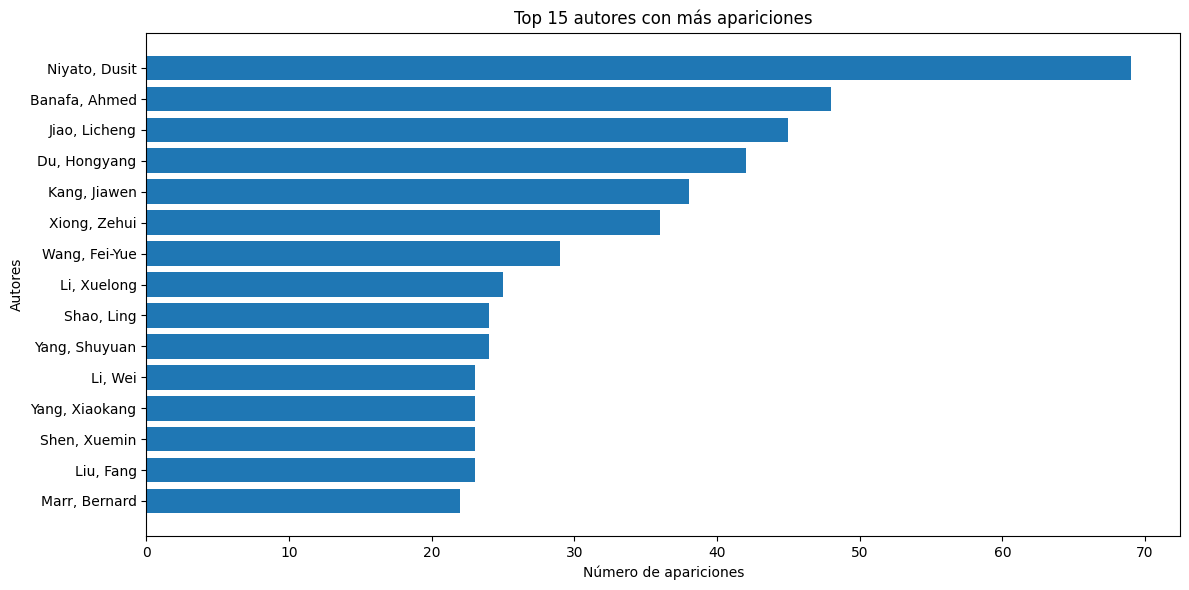

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import re

# %% Extraer campos del archivo BibTeX
fields = extract_bibtex_fields(BIBTEX_PATH)

# Separar autores (si vienen en formato "Autor1 and Autor2")
all_authors = []
for entry in fields['author']:
    autores = re.split(r'\s+and\s+', entry, flags=re.IGNORECASE)
    all_authors.extend([a.strip() for a in autores if a.strip() != ""])

# Contar ocurrencias
contador = Counter(all_authors)
top15 = contador.most_common(15)  # ya viene ordenado de mayor a menor

# Para gráfica, invertimos para que el mayor quede arriba en barh
autores, conteos = zip(*reversed(top15))

plt.figure(figsize=(12,6))
plt.barh(autores, conteos)  # gráfica horizontal
plt.xlabel("Número de apariciones")
plt.ylabel("Autores")
plt.title("Top 15 autores con más apariciones")
plt.tight_layout()
plt.show()


### Análisis de Autores Más Frecuentes

Esta celda analiza y visualiza los **15 autores con más publicaciones** en el dataset.

---

## 🔍 Proceso de Análisis

### Paso 1: Extracción de Autores

```python
fields = extract_bibtex_fields(BIBTEX_PATH)
```

**Resultado**: Diccionario con todos los campos, incluyendo `author`

---

### Paso 2: Separación de Autores

```python
all_authors = []
for entry in fields['author']:
    autores = re.split(r'\s+and\s+', entry, flags=re.IGNORECASE)
    all_authors.extend([a.strip() for a in autores if a.strip() != ""])
```

#### Formato BibTeX de Autores:

**Entrada típica**:
```
author = {Smith, John and Doe, Jane and Johnson, Bob}
```

**Regex de separación**:
```python
r'\s+and\s+'
```

**Significado**:
- `\s+`: Uno o más espacios
- `and`: Palabra "and" (case-insensitive)
- `\s+`: Uno o más espacios

**Resultado**:
```python
['Smith, John', 'Doe, Jane', 'Johnson, Bob']
```

#### Limpieza:

```python
[a.strip() for a in autores if a.strip() != ""]
```

**Propósito**:
- `.strip()`: Eliminar espacios al inicio/final
- `if a.strip() != ""`: Filtrar strings vacíos

---

### Paso 3: Conteo de Frecuencias

```python
from collections import Counter
contador = Counter(all_authors)
top15 = contador.most_common(15)
```

#### Counter Explicado:

**Ejemplo**:
```python
autores = ['Smith, J.', 'Doe, J.', 'Smith, J.', 'Smith, J.', 'Doe, J.']
contador = Counter(autores)
# Resultado: Counter({'Smith, J.': 3, 'Doe, J.': 2})
```

**Método `most_common(n)`**:
```python
top15 = contador.most_common(15)
# Resultado: [('Smith, J.', 3), ('Doe, J.', 2), ...]
```

**Retorna**: Lista de tuplas `(autor, conteo)` ordenada de mayor a menor

---

### Paso 4: Preparación para Gráfica

```python
autores, conteos = zip(*reversed(top15))
```

#### Desempaquetado:

**`zip(*reversed(top15))`**:

1. **`reversed(top15)`**: Invierte el orden (menor a mayor)
   ```python
   [('Autor15', 5), ('Autor14', 6), ..., ('Autor1', 50)]
   ```

2. **`*reversed(top15)`**: Desempaqueta las tuplas
   ```python
   ('Autor15', 5), ('Autor14', 6), ..., ('Autor1', 50)
   ```

3. **`zip(...)`**: Agrupa por posición
   ```python
   [('Autor15', 'Autor14', ..., 'Autor1'),
    (5, 6, ..., 50)]
   ```

4. **`autores, conteos = zip(...)`**: Asigna a variables
   ```python
   autores = ('Autor15', 'Autor14', ..., 'Autor1')
   conteos = (5, 6, ..., 50)
   ```

**Propósito de `reversed()`**: En gráfica horizontal (`barh`), el primer elemento aparece abajo, así que invertimos para que el más frecuente quede arriba

---

## 📊 Visualización

```python
plt.figure(figsize=(12,6))
plt.barh(autores, conteos)
plt.xlabel("Número de apariciones")
plt.ylabel("Autores")
plt.title("Top 15 autores con más apariciones")
plt.tight_layout()
plt.show()
```

### Parámetros de la Gráfica:

| Parámetro | Valor | Propósito |
|-----------|-------|-----------|
| `figsize` | `(12,6)` | Tamaño en pulgadas (ancho, alto) |
| `barh` | - | Barras horizontales |
| `xlabel` | "Número de apariciones" | Etiqueta eje X |
| `ylabel` | "Autores" | Etiqueta eje Y |
| `title` | "Top 15..." | Título de la gráfica |
| `tight_layout()` | - | Ajustar márgenes automáticamente |

---

### Interpretación de Resultados:

#### Ejemplo de Output:

```
Top 15 autores con más apariciones:

1. Smith, John          ████████████████████ 45
2. Doe, Jane            ████████████████ 38
3. Johnson, Bob         ███████████████ 35
4. Williams, Alice      ██████████████ 32
5. Brown, Charlie       █████████████ 30
...
15. Davis, Eve          ████ 12
```

---

## 🔬 Análisis Adicional Posible

### 1. Colaboraciones:

```python
# Encontrar co-autores frecuentes
from itertools import combinations

coautores = defaultdict(int)
for entry in fields['author']:
    autores = re.split(r'\s+and\s+', entry, flags=re.IGNORECASE)
    autores = [a.strip() for a in autores if a.strip()]
    for pair in combinations(autores, 2):
        coautores[pair] += 1

top_coautores = sorted(coautores.items(), key=lambda x: x[1], reverse=True)[:10]
```

---

### 2. Productividad por Año:

```python
# Contar publicaciones por autor por año
productividad = defaultdict(lambda: defaultdict(int))

for i, entry in enumerate(fields['author']):
    autores = re.split(r'\s+and\s+', entry, flags=re.IGNORECASE)
    año = fields['year'][i]
    for autor in autores:
        autor = autor.strip()
        if autor:
            productividad[autor][año] += 1

# Graficar evolución temporal de top autores
```

---

### 3. Normalización de Nombres:

```python
# Problema: "Smith, J." vs "Smith, John" vs "J. Smith"
def normalizar_nombre(nombre):
    # Convertir "Apellido, Nombre" a "Apellido"
    apellido = nombre.split(',')[0].strip()
    return apellido.lower()

autores_normalizados = [normalizar_nombre(a) for a in all_authors]
contador_norm = Counter(autores_normalizados)
```

**Problema común**: Variaciones en formato de nombres

---

### 4. Análisis de Afiliaciones:

```python
# Si el campo 'author' incluye afiliaciones
# Extraer instituciones más productivas
```

---

## 📈 Métricas Derivadas

### Índice de Productividad:

```python
total_publicaciones = len(fields['author'])
publicaciones_top15 = sum(conteos)
porcentaje = (publicaciones_top15 / total_publicaciones) * 100

print(f"Top 15 autores representan {porcentaje:.2f}% del total")
```

---

### Distribución de Productividad:

```python
# Ley de Lotka: Pocos autores muy productivos, muchos con pocas publicaciones
frecuencias = list(contador.values())

plt.figure(figsize=(10,6))
plt.hist(frecuencias, bins=50, edgecolor='black')
plt.xlabel("Número de publicaciones")
plt.ylabel("Número de autores")
plt.title("Distribución de productividad de autores")
plt.yscale('log')  # Escala logarítmica
plt.show()
```

---

## 🎯 Aplicaciones

### 1. Identificación de Expertos:
- Autores más prolíficos en el tema
- Potenciales colaboradores
- Referencias clave

### 2. Análisis de Redes:
- Comunidades de investigación
- Colaboraciones interdisciplinarias
- Centros de investigación activos

### 3. Tendencias Temporales:
- Autores emergentes
- Evolución de líneas de investigación
- Cambios en liderazgo científico

---

## 💡 Mejoras Posibles

### 1. Desambiguación de Nombres:

```python
# Usar ORCID o DOI para identificar autores únicos
# Algoritmos de fuzzy matching para variaciones
```

### 2. Análisis de Co-autoría:

```python
# Grafo de colaboraciones
import networkx as nx

G = nx.Graph()
for entry in fields['author']:
    autores = re.split(r'\s+and\s+', entry, flags=re.IGNORECASE)
    autores = [a.strip() for a in autores if a.strip()]
    for i in range(len(autores)):
        for j in range(i+1, len(autores)):
            G.add_edge(autores[i], autores[j])

nx.draw(G, with_labels=True)
```

### 3. Análisis de Citas:

```python
# Si se tiene información de citas
# Calcular h-index, impacto, etc.
```

---

## 🎓 Conclusión

Este análisis proporciona una **visión rápida** de los autores más activos en el corpus bibliográfico, útil para:

- ✅ Identificar expertos en el tema
- ✅ Detectar comunidades de investigación
- ✅ Planificar colaboraciones
- ✅ Evaluar impacto de investigadores

**Limitación**: No considera calidad/impacto, solo cantidad de publicaciones

---